In [1]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spike_data_binned = np.load('/home/linggel/neuroscience/standard_data_format/spike_data_binned.npy')
lfp_data_sampled = np.load('/home/linggel/neuroscience/standard_data_format/lfp_data_sampled.npy')
lfp_data_sampled = np.swapaxes(lfp_data_sampled, 1, 2)
trial_info = np.load('/home/linggel/neuroscience/standard_data_format/trial_info.npy')

In [3]:
print(spike_data_binned.shape)
print(lfp_data_sampled.shape)

(245, 46, 400)
(245, 21, 400)


In [4]:
rat_correct = trial_info[:, 0] == 1
in_sequence = trial_info[:, 1] == 1
not_odor_e = trial_info[:, 3] < 5
select = rat_correct & in_sequence & not_odor_e

In [5]:
decoding_start = 210
decoding_end = decoding_start + 25

In [6]:
decoding_data_spike = spike_data_binned[select, :, decoding_start:decoding_end]
decoding_data_lfp = lfp_data_sampled[select, :, decoding_start:decoding_end]

In [7]:
decoding_data_spike = (decoding_data_spike - np.mean(decoding_data_spike)) / np.std(decoding_data_spike)

In [8]:
from keras.utils import np_utils

Using Theano backend.


In [9]:
decoding_target = np_utils.to_categorical((trial_info[select, 3] - 1).astype(int))

In [10]:
tetrode_ids = [1, 10, 12, 13, 14, 15, 16, 18, 19, 2, 20, 21, 22, 23, 3, 4, 5, 6, 7, 8, 9]

In [11]:
tetrode_units = {1:3, 10:0, 12:1, 13:8, 14:4, 15:6, 16:1, 18:0, 19:4, 2:3,
                20:0, 21:1, 22:5, 23:7, 3:0, 4:0, 5:0, 6:0, 7:1, 8:1, 9:1}

In [14]:
from data_utils import *
from tetrode import *

/home/linggel/anaconda2/envs/deeplearning/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [15]:
tetrode_data = organize_tetrode(decoding_data_spike, decoding_data_lfp, tetrode_ids, tetrode_units)

Current tetrode 1 with 3 neurons/units
(168, 1, 4, 25)
Current tetrode 12 with 1 neurons/units
(168, 1, 2, 25)
Current tetrode 13 with 8 neurons/units
(168, 1, 9, 25)
Current tetrode 14 with 4 neurons/units
(168, 1, 5, 25)
Current tetrode 15 with 6 neurons/units
(168, 1, 7, 25)
Current tetrode 16 with 1 neurons/units
(168, 1, 2, 25)
Current tetrode 19 with 4 neurons/units
(168, 1, 5, 25)
Current tetrode 2 with 3 neurons/units
(168, 1, 4, 25)
Current tetrode 21 with 1 neurons/units
(168, 1, 2, 25)
Current tetrode 22 with 5 neurons/units
(168, 1, 6, 25)
Current tetrode 23 with 7 neurons/units
(168, 1, 8, 25)
Current tetrode 7 with 1 neurons/units
(168, 1, 2, 25)
Current tetrode 8 with 1 neurons/units
(168, 1, 2, 25)
Current tetrode 9 with 1 neurons/units
(168, 1, 2, 25)


In [16]:
model = build_tetrode_model(tetrode_ids, tetrode_units)

In [17]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 4, 25)      0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 1, 2, 25)      0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 1, 9, 25)      0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 1, 5, 25)      0                                            
___________________________________________________________________________________________

In [55]:
y_true, y_hat = cross_validate(tetrode_data, decoding_target, tetrode_ids, tetrode_units)

Current fold validation accuracy: 0.736842095852
Current fold validation accuracy: 0.777777791023
Current fold validation accuracy: 0.764705896378
Current fold validation accuracy: 0.764705896378
Current fold validation accuracy: 0.823529422283
Current fold validation accuracy: 0.823529422283
Current fold validation accuracy: 0.882352948189
Current fold validation accuracy: 0.8125
Current fold validation accuracy: 0.866666674614
Current fold validation accuracy: 0.866666674614


In [58]:
np.mean(y_true.argmax(-1) == y_hat.argmax(-1))

0.72023809523809523

In [59]:
from sklearn.metrics import confusion_matrix

In [60]:
matrix = confusion_matrix(y_true.argmax(-1), y_hat.argmax(-1))
print(matrix)

[[57  1  0  0]
 [ 2 30  5  4]
 [ 1  4 19 13]
 [ 3  3 11 15]]


In [61]:
import itertools

In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=14)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=14)
    plt.xlabel('Predicted label', fontsize=14)

Normalized confusion matrix
[[ 0.98275862  0.01724138  0.          0.        ]
 [ 0.04878049  0.73170732  0.12195122  0.09756098]
 [ 0.02702703  0.10810811  0.51351351  0.35135135]
 [ 0.09375     0.09375     0.34375     0.46875   ]]


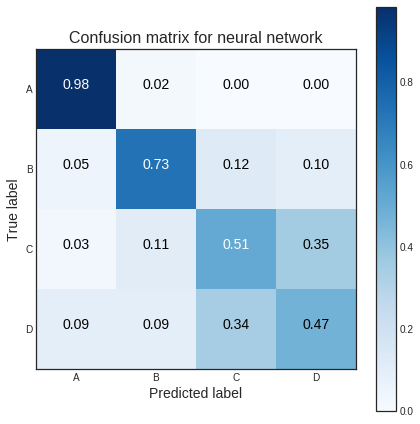

In [63]:
fig = plt.figure(figsize=(6, 6))
plt.style.use('seaborn-white')
plot_confusion_matrix(matrix, classes=['A', 'B', 'C', 'D'], normalize=True,
                      title='Confusion matrix for neural network')
plt.show()